In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Import Data Frame and view data
df = pd.read_csv('time_data.csv',sep=',')
# df = df.drop(columns = ['High','Low', 'Close','Adj_Close'])
print(len(df))
df

25


,time,conv
0,0,0.000000
1,5,3.289106
2,10,6.685466
3,15,9.974572
4,20,12.655909
5,25,14.622222
6,30,17.947079
7,35,20.378158
8,40,22.451725
9,45,23.059494


In [3]:
def get_column_names(dataframe):
    # Parse Column for names and get names in list
    column_names=[]
    for col in dataframe.columns:
        column_names.append(col)
    return column_names
    
names = get_column_names(df)


In [4]:
def create_arrays(dataframe, num_data):
    # get the number of columns in the DataFrame
    num_cols = len(dataframe.columns)

    # create an empty list to hold the arrays
    arrays = []

    # loop over the columns and assign each to a numbered array
    for i in range(num_cols):
        col_name = dataframe.columns[i]
        col_array = np.zeros(num_data)
        for j in range(num_data):
            col = dataframe[col_name].values
            col_array[j] = col[j]
        arrays.append(col_array)
    
    # arrays now contains a list of NumPy arrays, each corresponding to a column of the DataFrame
    return arrays

In [5]:
def create_tensors(arrays):
    # Creates the tensors for neural network
    num_data = len(arrays[0])
    num_arrays = len(arrays)
    train_data = torch.zeros((num_data, num_arrays))
    # Takes the arrays and turns them into tensors
    for i in range(num_arrays):
        train_data[:, i] = torch.from_numpy(arrays[i])

    # create the labels tensor
    train_labels = torch.zeros(num_data)
    # Zip the tensors and tensor labels
    train_set = [(train_data[i], train_labels[i]) for i in range(num_data)]
    return train_set


In [6]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 25
# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.002
# number of epoch
num_epochs = 200
# Discriminator dropout
drop_out=0.3
# Define batch size for the data loader
batch_size = 5


# These create the arrays and then turns them into tensors for the train loader 
arrays = create_arrays(df,num_data)
train_set = create_tensors(arrays)

In [7]:
# The train loader loads the data into the neural network trainer
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

Discriminator and Generator

In [8]:
class Discriminator(nn.Module):
    # Classifies data as real or synthetic, used to train generator
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size*8)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*8), (batch_size*4)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*4), (batch_size*2)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

In [9]:
class Generator(nn.Module):
    # Generates synthetic data
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size)),
            nn.ReLU(),
            nn.Linear((batch_size), (batch_size*2)),
            nn.ReLU(),
            nn.Linear((batch_size*2), df_dim),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [10]:
# loss function
loss_function = nn.BCELoss()
# Optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
# This is where the generator and discrimator are trained
for epoch in range(num_epochs):

    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, df_dim))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, df_dim))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 2.5140938758850098
Epoch: 0 Loss G.: 0.8111476898193359
Epoch: 10 Loss D.: 0.4090436100959778
Epoch: 10 Loss G.: 0.8499754071235657
Epoch: 20 Loss D.: 0.3159870207309723
Epoch: 20 Loss G.: 1.031069040298462
Epoch: 30 Loss D.: 0.15063557028770447
Epoch: 30 Loss G.: 1.0992900133132935
Epoch: 40 Loss D.: 0.24086828529834747
Epoch: 40 Loss G.: 1.4522758722305298
Epoch: 50 Loss D.: 0.23650820553302765
Epoch: 50 Loss G.: 1.1227266788482666
Epoch: 60 Loss D.: 0.2003997564315796
Epoch: 60 Loss G.: 0.8036044836044312
Epoch: 70 Loss D.: 0.26779332756996155
Epoch: 70 Loss G.: 1.0070998668670654
Epoch: 80 Loss D.: 0.32642844319343567
Epoch: 80 Loss G.: 0.9055622816085815
Epoch: 90 Loss D.: 0.6041439175605774
Epoch: 90 Loss G.: 0.956882119178772
Epoch: 100 Loss D.: 0.39463210105895996
Epoch: 100 Loss G.: 0.9516169428825378
Epoch: 110 Loss D.: 0.4288733899593353
Epoch: 110 Loss G.: 0.931371808052063
Epoch: 120 Loss D.: 0.6604235172271729
Epoch: 120 Loss G.: 0.9877350926399231
Epoch

In [17]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [18]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples)
df_gen = df_gen.set_axis(names, axis=1, inplace=False)
df_gen

,time,conv
0,99.799599,46.492699
1,58.443790,27.554188
2,92.634300,43.374176
3,56.469090,26.880701
4,100.090858,46.601513
5,28.263205,13.826803
6,38.183369,18.466497
7,27.725788,13.628135
8,62.010067,29.262445
9,48.231209,23.109594


(0.0, 60.0)

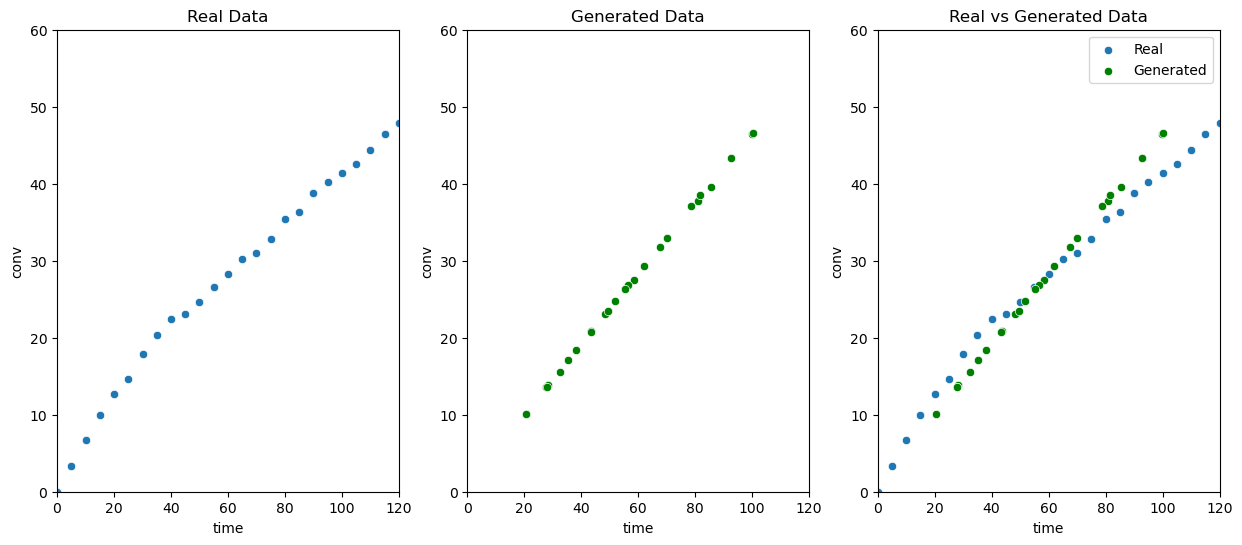

In [19]:
# Plotting Real vs Generated data
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[2].set_title('Real vs Generated Data')
sns.scatterplot(ax=axes[0],x='time', y='conv', data=df)
axes[0].set_title('Real Data')
axes[0].set_xlim(0, 120)
axes[0].set_ylim(0, 60)
sns.scatterplot(ax=axes[1], data=df_gen,x='time', y='conv', color='g')
axes[1].set_title('Generated Data')
axes[1].set_ylim(0, 60)
axes[1].set_xlim(0, 120)
sns.scatterplot(ax=axes[2], data=df, x='time', y='conv', label='Real')
sns.scatterplot(ax=axes[2], data=df_gen, x='time', y='conv', color='g', label= 'Generated')
axes[2].set_title('Real vs Generated Data')
axes[2].set_xlim(0, 120)
axes[2].set_ylim(0, 60)

In [16]:
print('Current Model Parameters:')
print('Size of dataset:', num_data)
print('Number of epochs:', num_epochs)
print('Learning Rate:', lr)
print('Discriminator dropout:', drop_out)
print('Batch Size:', batch_size)

Current Model Parameters:
Size of dataset: 25
Number of epochs: 200
Learning Rate: 0.002
Discriminator dropout: 0.3
Batch Size: 5
